<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

## Caso 1

In [92]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re


# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer

import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)
# Otros
# -----------------------------------------------------------------------
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
def clean_string(string, nlp, stopwords):
    symbol_pattern = r"[^a-zA-Z\s]"
    
    str_low = string.lower()
    str_no_sym = re.sub(pattern = symbol_pattern, repl = "", string = str_low)
    str_no_linebreak = re.sub(pattern = "\n", repl=" ", string = str_no_sym)
    str_no_double = re.sub(pattern = r"\s\s+", repl = " ", string = str_no_linebreak)
    str_clean = contractions.fix(str_no_double.strip())

    doc = nlp(str_clean)

    tokens = [token.lemma_ for token in doc if token.text not in stopwords]

    return tokens

In [3]:
df = pd.read_csv("datos/datos.csv", index_col=0)

In [4]:
df.reset_index(drop = True, inplace = True)

In [5]:
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


Para no tratar con nombres de productos, los cuales son muy largos, creamos un diccionario que nos servirá para mapear y crear un ID único para cada producto.

In [6]:
dict_products = dict(enumerate(df["productName"].unique(), start = 1))
dict_ids = {v : k for k, v in dict_products.items()}

In [7]:
df["productID"] = df["productName"].map(dict_ids)

Además, ya que vamos a agrupar por los productos, vamos a almacenar las medianas de las puntuaciones de cada uno, para poder luego aportar esta información en las recomendaciones.

In [8]:
product_stars = df.groupby("productID")["reviewStar"].median().reset_index()

### Sistema de Recomendación basado en reviews:

In [9]:
nlp = spacy.load("en_core_web_sm")
en_stopwords = set(stopwords.words("english"))

Comprobemos los nulos en las reseñas.

In [10]:
df["reviewText"].isna().sum()

np.int64(1)

Vemos que solo hay 1 nulo en nuestras reviews, por lo que podemos dropear.

In [11]:
df.dropna(subset="reviewText", inplace=True)

Para el caso de las reviews, es importante el contexto de el texto completo, por lo que la mejor opción será considerar un método de embedding, ya que este será capaz de identificar las opiniones.

In [12]:
df_grouped_reviews = df.groupby("productID")["reviewText"].sum()

Iniciamos el modelo BERT.

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [14]:
def get_embedding(texts):
    """
    Genera embeddings para una lista de textos utilizando un modelo preentrenado.

    Esta función utiliza un tokenizer y un modelo de lenguaje preentrenados (como los de 
    Hugging Face) para convertir textos en representaciones numéricas (embeddings). 
    Los embeddings se calculan tomando la media de las activaciones del último estado 
    oculto del modelo.

    Parámetros:
    texts (list[str] o str): Lista de textos (o un único texto) para los cuales se 
                             generarán los embeddings.

    Devuelve:
    torch.Tensor: Tensor que contiene los embeddings generados. La forma del tensor será 
                  (N, D), donde N es el número de textos y D es la dimensión del embedding 
                  generado por el modelo.

    Ejemplo:
    >>> texts = ["Hola, ¿cómo estás?", "Esto es un ejemplo."]
    >>> embeddings = get_embedding(texts)
    >>> print(embeddings.shape)
    torch.Size([2, 768])  # Suponiendo que el modelo devuelve embeddings de 768 dimensiones.
    """
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(axis=1)
    return embeddings



In [15]:
embedded_reviews = get_embedding(list(df_grouped_reviews))

In [16]:
df_embedded = pd.DataFrame(embedded_reviews, columns = [f"emb_{i}" for i in range(1, embedded_reviews.shape[1]+1)])

In [17]:
df_embedded["productID"] = df_grouped_reviews.index
df_embedded.set_index("productID", inplace=True)

In [18]:
df_embedded.head()

,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,emb_300,emb_301,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311,emb_312,emb_313,emb_314,emb_315,emb_316,emb_317,emb_318,emb_319,emb_320,emb_321,emb_322,emb_323,emb_324,emb_325,emb_326,emb_327,emb_328,emb_329,emb_330,emb_331,emb_332,emb_333,emb_334,emb_335,emb_336,emb_337,emb_338,emb_339,emb_340,emb_341,emb_342,emb_343,emb_344,emb_345,emb_346,emb_347,emb_348,emb_349,emb_350,emb_351,emb_352,emb_353,emb_354,emb_355,emb_356,emb_357,emb_358,emb_359,emb_360,emb_361,emb_362,emb_363,emb_364,emb_365,emb_366,emb_367,emb_368,emb_369,emb_370,emb_371,emb_372,emb_373,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383,emb_384,emb_385,emb_386,emb_387,emb_388,emb_389,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399,emb_400,emb_401,emb_402,emb_403,emb_404,emb_405,emb_406,emb_407,emb_408,emb_409,emb_410,emb_411,emb_412,emb_413,emb_414,emb_415,emb_416,emb_417,emb_418,emb_419,emb_420,emb_421,emb_422,emb_423,emb_424,emb_425,emb_426,emb_427,emb_428,emb_429,emb_430,emb_431,emb_432,emb_433,emb_434,emb_435,emb_436,emb_437,emb_438,emb_439,emb_440,emb_441,emb_442,emb_443,emb_444,emb_445,emb_446,emb_447,emb_448,emb_449,emb_450,emb_451,emb_452,emb_453,emb_454,emb_455,emb_456,emb_457,emb_458,emb_459,emb_460,emb_461,emb_462,emb_463,emb_464,emb_465,emb_466,emb_467,emb_468,emb_469,emb_470,emb_471,emb_472,emb_473,emb_474,emb_475,emb_476,emb_477,emb_478,emb_479,emb_480,emb_481,emb_482,emb_483,emb_484,emb_485,emb_486,emb_487,emb_488,emb_489,emb_490,emb_491,emb_492,emb_493,emb_494,emb_495,emb_496,emb_497,emb_498,emb_499,emb_500,emb_501,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511,emb_512,emb_513,emb

In [19]:
df_review_similarity = pd.DataFrame(cosine_similarity(df_embedded), columns = df_embedded.index, index = df_embedded.index)

In [20]:
df_review_similarity.head()

productID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
productID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.932935,0.913343,0.912515,0.920713,0.933115,0.910045,0.917942,0.922256,0.932412,0.935874,0.928366,0.917734,0.938210,0.947273,0.920750,0.934384,0.942111,0.934460,0.932133,0.915621,0.923973,0.950658,0.916942,0.919876,0.926444,0.917140,0.945788,0.946303,0.929896,0.931883,0.944730,0.898870,0.959377,0.942560,0.941915,0.951834,0.912966,0.914356,0.935428,0.912201,0.907519,0.921286,0.922866,0.641030,0.942049,0.899933,0.947312,0.939768,0.945938,0.922943,0.943349,0.915937,0.925406,0.905490,0.920108,0.922412,0.920297,0.946777,0.908056,0.912070,0.926097,0.934581,0.917532,0.945099,0.926782,0.899241,0.943223,0.948150,0.925781,0.937904,0.933374,0.931037,0.932890,0.900052,0.850121,0.934394,0.957637,0.907443,0.917852,0.920280,0.944468,0.907641,0.925308,0.910403,0.944256,0.921805,0.936747,0.953615,0.905126,0.942811,0.853565,0.936555,0.795941,0.715301,0.896144,0.635257,0.731493,0.900641
2,0.932935,1.000000,0.880926,0.908331,0.910623,0.924434,0.889474,0.914722,0.913525,0.936494,0.908364,0.921186,0.896093,0.930088,0.925473,0.945633,0.933365,0.920219,0.937129,0.911128,0.887657,0.933358,0.919954,0.895800,0.922785,0.918875,0.897679,0.938712,0.921704,0.914501,0.924500,0.943669,0.885406,0.936322,0.925835,0.930778,0.928508,0.892095,0.894582,0.907384,0.865385,0.911478,0.908282,0.887397,0.669443,0.930559,0.887118,0.949568,0.965881,0.945675,0.899553,0.920669,0.913471,0.906097,0.921003,0.903348,0.909141,0.901979,0.936584,0.886086,0.890467,0.919995,0.928368,0.951522,0.954010,0.932912,0.879867,0.963996,0.928432,0.918403,0.931631,0.905527,0.939274,0.966157,0.880566,0.825337,0.917980,0.951397,0.878601,0.877447,0.893856,0.951429,0.888821,0.907701,0.893899,0.921934,0.909113,0.932189,0.937593,0.904734,0.921595,0.829436,0.906614,0.806455,0.769642,0.871038,0.677162,0.773669,0.877748
3,0.913343,0.880926,1.000000,0.901705,0.886947,0.937253,0.944211,0.901394,0.887785,0.898234,0.939462,0.906451,0.952294,0.902761,0.944707,0.888490,0.918304,0.941409,0.890082,0.896868,0.956024,0.902270,0.898551,0.953015,0.907097,0.927712,0.956412,0.904329,0.913073,0.949402,0.944142,0.913169,0.929347,0.908260,0.909416,0.927668,0.917789,0.933519,0.945917,0.947898,0.938234,0.899062,0.890431,0.934195,0.704929,0.938309,0.913539,0.911151,0.897808,0.909905,0.955143,0.934372,0.929790,0.966810,0.897533,0.897890,0.895064,0.930899,0.918208,0.947082,0.944464,0.902318,0.943959,0.887230,0.895605,0.910062,0.939148,0.885596,0.923230,0.908175,0.940136,0.924586,0.896688,0.885055,0.923518,0.922042,0.884134,0.895164,0.965104,0.946875,0.955869,0.890271,0.948123,0.903610,0.904148,0.922034,0.921151,0.921737,0.911907,0.890709,0.911409,0.930143,0.933551,0.833894,0.707585,0.940071,0.682748,0.695269,0.942102
4,0.912515,0.908331,0.901705,1.000000,0.925878,0.913666,0.916606,0.919132,0.934362,0.916333,0.911465,0.923623,0.917745,0.932188,0.930359,0.947199,0.933515,0.922184,0.923666,0.903955,0.899492,0.940653,0.918071,0.896145,0.917975,0.912897,0.903854,0.942733,0.947821,0.928645,0.930881,0.948842,0.928030,0.921907,0.931102,0.942004,0.924451,0.925551,0.909494,0.915814,0.910321,0.919008,0.917350,0.914093,0.653450,0.927636,0.936626,0.910964,0.924746,0.932582,0.919739,0.928616,0.899594,0.916177,0.927351,0.924130,0.936099,0.928873,0.937864,0.920098,0.913443,0.943446,0.914979,0.921795,0.926991,0.937243,0.920494,0.915604,0.933647,0.945305,0.916982,0.935818,0.931693,0.910469,0.933183,0.844830,0.926108,0.930446,0.918771,0.902656,0.883013,0.917615,0.925025,0.922374,0.950909,0.926681,0.939800,0.952565,0.947258,0.903011,0.923011,0.883851,0.931702,0.806087,0.715374,0.919084,0.634648,0.708072,0.936447
5,0.920713,0.910623,0

In [21]:
def get_recs_from_review(product_id, n_recs=10, print_prod=True):
    """
    Genera recomendaciones basadas en la similitud de reseñas para un producto dado.

    Esta función devuelve los productos más similares a un producto específico, según 
    una métrica de similitud calculada previamente entre las reseñas de los productos. 
    Puede imprimir información sobre el producto principal y devuelve un DataFrame con 
    los productos recomendados.

    Parámetros:
    product_id (int o str): ID del producto para el cual se generan las recomendaciones.
    n_recs (int, opcional): Número de recomendaciones a devolver. Por defecto es 10.
    print_prod (bool, opcional): Si es True, imprime el nombre del producto principal 
                                 basado en `dict_products`. Por defecto es True.

    Devuelve:
    pandas.DataFrame: DataFrame con las siguientes columnas:
        - `productID`: ID del producto recomendado.
        - `similarity`: Valor de similitud con el producto principal.
        - `productName`: Nombre del producto recomendado.
        - Otras columnas dependiendo de las uniones realizadas, como `product_stars`.

    Ejemplo:
    >>> recommendations = get_recs_from_review(12345, n_recs=5, print_prod=False)
    >>> print(recommendations)
       productID  similarity       productName     stars
    0      67890       0.95    Producto Ejemplo     4.5
    1      23456       0.92    Otro Producto       4.2

    Notas:
    - Se asume que `dict_products` es un diccionario que mapea IDs de productos a sus nombres.
    - `df_review_similarity` es un DataFrame que contiene valores de similitud entre productos.
    - `product_stars` es un DataFrame con información adicional de los productos, como puntuaciones.

    """
    if print_prod:
        print(dict_products[product_id])
    similarities = df_review_similarity[product_id].rename("similarity").sort_values(ascending=False).iloc[1:].reset_index()
    similarities["productName"] = similarities["productID"].map(dict_products)
    similarities = similarities.merge(right=product_stars, left_on="productID", right_on="productID")
    return similarities.head(n_recs)


In [22]:
get_recs_from_review(29)

AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml


,productID,similarity,productName,reviewStar
0,52,0.967134,Finishing Touch Flawless Women's Painless Hair...,3.0
1,14,0.964603,Hard As Hoof Nail Strengthening Cream with Coc...,3.0
2,35,0.964576,"NYX PROFESSIONAL MAKEUP Epic Ink Liner, Waterp...",3.0
3,36,0.963528,REVLON One-Step Hair Dryer And Volumizer Hot A...,3.0
4,9,0.963501,"Physicians Formula, Murumuru Butter, Bronzer, ...",3.0
5,57,0.962338,Neutrogena Hydro Boost Hyaluronic Acid Hydrati...,3.0
6,50,0.961986,Maybelline Instant Age Rewind Eraser Dark Circ...,3.0
7,62,0.961035,"Bio-Oil Skincare Oil, Body Oil for Scars and S...",3.0
8,59,0.958795,Avarelle Acne Pimple Patch (40 Count) Absorbin...,3.0
9,32,0.957015,Fit Simplify Resistance Loop Exercise Bands wi...,3.0


### Sistema de Recomendación basado en nombre de producto:

Viendo los nombres de nuestros productos vemos que contienen información que podría indicar el tipo de producto con el que nos encontramos.

In [23]:
print(df["productName"].sample().values)

['Cremo Blue Cedar & Cypress Cologne Spray, A Woodsy Scent with Notes of Lemon Peel, Cypress and Cedar, 3.4 Oz']


Para el nombre vamos a usar un Bag of Words con un TfidfVectorizer, para que aquellos productos con palabras clave similares sean catalogados como más parecidos y no tener tanto en cuenta aquellas palabras que aparezcan en muchos otros productos.

Para este necesitaremos tokenizar previamente, y para ello usaremos la función ``clean_string``.

In [24]:
df["productNameToken"] = df["productName"].apply(lambda x: clean_string(x, nlp, en_stopwords))

In [25]:
df["productNameClean"] = df["productNameToken"].apply(lambda x: " ".join(x))

In [26]:
vectorizer = TfidfVectorizer(max_features=1000)

df_vect = pd.DataFrame(vectorizer.fit_transform(df["productNameClean"].unique()).toarray(),
                       columns = vectorizer.get_feature_names_out())
df_vect["productID"] = df["productID"].unique()
df_vect = df_vect.set_index("productID")

In [27]:
df_product_similarity = pd.DataFrame(cosine_similarity(df_vect), columns=df_vect.index, index=df_vect.index)

In [28]:
def get_recs_from_product(product_id, n_recs=10, print_prod=True):
    """
    Genera recomendaciones de productos basadas en la similitud de características.

    Esta función devuelve los productos más similares a un producto específico, según 
    una métrica de similitud calculada previamente. Opcionalmente, imprime el nombre 
    del producto principal.

    Parámetros:
    product_id (int o str): ID del producto para el cual se generan las recomendaciones.
    n_recs (int, opcional): Número de recomendaciones a devolver. Por defecto es 10.
    print_prod (bool, opcional): Si es True, imprime el nombre del producto principal 
                                 basado en `dict_products`. Por defecto es True.

    Devuelve:
    pandas.DataFrame: DataFrame con las siguientes columnas:
        - `productID`: ID del producto recomendado.
        - `similarity`: Valor de similitud con el producto principal.
        - `productName`: Nombre del producto recomendado.
        - Otras columnas dependiendo de las uniones realizadas, como `product_stars`.
    """
    if print_prod:
        print(dict_products[product_id])
    similarities = df_product_similarity[product_id].rename("similarity").sort_values(ascending=False).iloc[1:].reset_index()
    similarities["productName"] = similarities["productID"].map(dict_products)
    similarities = similarities.merge(right=product_stars, left_on="productID", right_on="productID")
    return similarities.head(n_recs)


In [29]:
get_recs_from_product(29)

AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml


,productID,similarity,productName,reviewStar
0,14,0.243876,Hard As Hoof Nail Strengthening Cream with Coc...,3.0
1,77,0.216256,Harperton Nail Clippers Set - 2 Pack Stainless...,3.0
2,22,0.114915,Beckham Hotel Collection Bed Pillows for Sleep...,3.0
3,5,0.102533,WOW Apple Cider Vinegar Shampoo and Hair Condi...,3.0
4,57,0.080377,Neutrogena Hydro Boost Hyaluronic Acid Hydrati...,3.0
5,52,0.060562,Finishing Touch Flawless Women's Painless Hair...,3.0
6,42,0.055136,Nautica Voyage By Nautica For Men Eau De Toile...,3.0
7,47,0.049943,"Magic Bullet Blender, Small, Silver, 11 Piece Set",3.0
8,58,0.047150,iJoy Matte Finish Premium Rechargeable Wireles...,3.0
9,32,0.039292,Fit Simplify Resistance Loop Exercise Bands wi...,3.0


In [30]:
def get_compound_rec(product_id, review_weight=0.5, n_recs=10):
    """
    Genera recomendaciones combinadas basadas en similitud de características de producto y reseñas.

    Esta función calcula una métrica de similitud compuesta al combinar las similitudes de productos 
    y reseñas, ponderadas según el peso asignado a las reseñas. Devuelve los productos más similares 
    al producto especificado.

    Parámetros:
    product_id (int o str): ID del producto para el cual se generan las recomendaciones.
    review_weight (float, opcional): Peso asignado a la similitud basada en reseñas. 
                                      Debe estar en el rango [0, 1]. Por defecto es 0.5.
    n_recs (int, opcional): Número de recomendaciones a devolver. Por defecto es 10.

    Devuelve:
    pandas.DataFrame: DataFrame con las siguientes columnas:
        - `similarity`: Similitud compuesta calculada para cada producto.
        - `reviewStar`: Puntuación de reseñas del producto.
        - `productName`: Nombre del producto recomendado.
    """
    print(dict_products[product_id])
    prod_recs = get_recs_from_product(product_id, len(product_stars), print_prod=False)
    rev_recs = get_recs_from_review(product_id, len(product_stars), print_prod=False)
    merged = prod_recs.merge(rev_recs, how="outer", left_on="productID", right_on="productID")
    result = pd.DataFrame()
    result["similarity"] = review_weight * merged["similarity_y"] + (1 - review_weight) * merged["similarity_x"]
    result["reviewStar"] = merged["reviewStar_x"]
    result["productName"] = merged["productName_x"]
    return result.sort_values(by="similarity", ascending=False).head(n_recs)


In [127]:
get_compound_rec(29, review_weight=0.5)

AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml


,similarity,reviewStar,productName
13,0.604240,3.0,Hard As Hoof Nail Strengthening Cream with Coc...
75,0.583859,3.0,Harperton Nail Clippers Set - 2 Pack Stainless...
21,0.526360,3.0,Beckham Hotel Collection Bed Pillows for Sleep...
4,0.525534,3.0,WOW Apple Cider Vinegar Shampoo and Hair Condi...
55,0.521358,3.0,Neutrogena Hydro Boost Hyaluronic Acid Hydrati...
50,0.513848,3.0,Finishing Touch Flawless Women's Painless Hair...
40,0.499316,3.0,Nautica Voyage By Nautica For Men Eau De Toile...
30,0.498153,3.0,Fit Simplify Resistance Loop Exercise Bands wi...
45,0.496013,3.0,"Magic Bullet Blender, Small, Silver, 11 Piece Set"
56,0.490659,3.0,iJoy Matte Finish Premium Rechargeable Wireles...


## Caso 2

In [131]:
sia = SentimentIntensityAnalyzer()

In [39]:
df["reviewTextToken"] = df["reviewText"].apply(lambda x : clean_string(x, nlp = nlp, stopwords=en_stopwords))

In [43]:
df_w_sentiment = pd.concat([df,df["reviewTextToken"].apply(lambda x : sia.polarity_scores(" ".join(x))).apply(pd.Series)], axis = 1)

In [85]:
df_w_sentiment.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,productID,productNameToken,productNameClean,reviewTextToken,neg,neu,pos,compound
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1,1,"[doctor, develop, copper, wrist, brace, carpal...",doctor develop copper wrist brace carpal tunne...,"[nice, lightweight, brace, unfortunately, larg...",0.121,0.603,0.276,0.4767
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0,2,"[fruit, loom, men, coolzone, boxer, brief]",fruit loom men coolzone boxer brief,"[boxer, ok, color, start, fade, pretty, quickl...",0.138,0.539,0.323,0.4767
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0,3,"[tplink, ac, wifi, extender, cover, sqft, devi...",tplink ac wifi extender cover sqft device mbps...,"[easy, install, work, right, away, go, far, ex...",0.000,0.523,0.477,0.8020
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1,4,"[gorilla, grip, luxury, chenille, bathroom, ru...",gorilla grip luxury chenille bathroom rug mat ...,"[color, completely, different, hunter, green, ...",0.000,1.000,0.000,0.0000
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0,5,"[wow, apple, cider, vinegar, shampoo, hair, co...",wow apple cider vinegar shampoo hair condition...,"[read, review, hope, shampoo, conditioner, wou...",0.000,0.541,0.459,0.8979


Ahora podemos comprobar si las estrellas con las que puntúan los usuarios son métricas indicativas de cómo se sienten con respecto al producto.

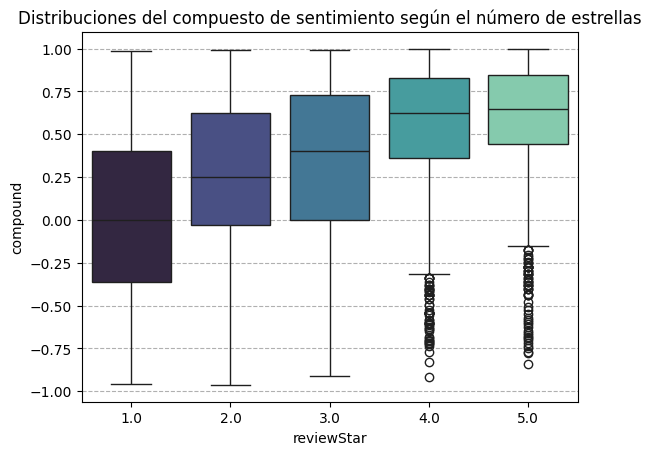

In [96]:
plt.figure()
plt.title("Distribuciones del compuesto de sentimiento según el número de estrellas")
plt.grid(ls = "--")
sns.boxplot(data = df_w_sentiment, x = "reviewStar", y = "compound", palette = "mako")
plt.show()

Vemos que, aunque hayan muchos valores atípicos, las estrellas sí que indican el sentimiento general de los compradores. Un hecho curioso es que las reviews con 1 estrella tienen de mediana un sentimiento neutro, con una distribución bastante equitativa de las positivas y negativas. Además, el criterio general de las estrellas invita a pensar que la gente tiene opiniones de todos tipos, pero cuanto mejor puntuaje menor número de personas opinan de forma negativa sobre el producto.

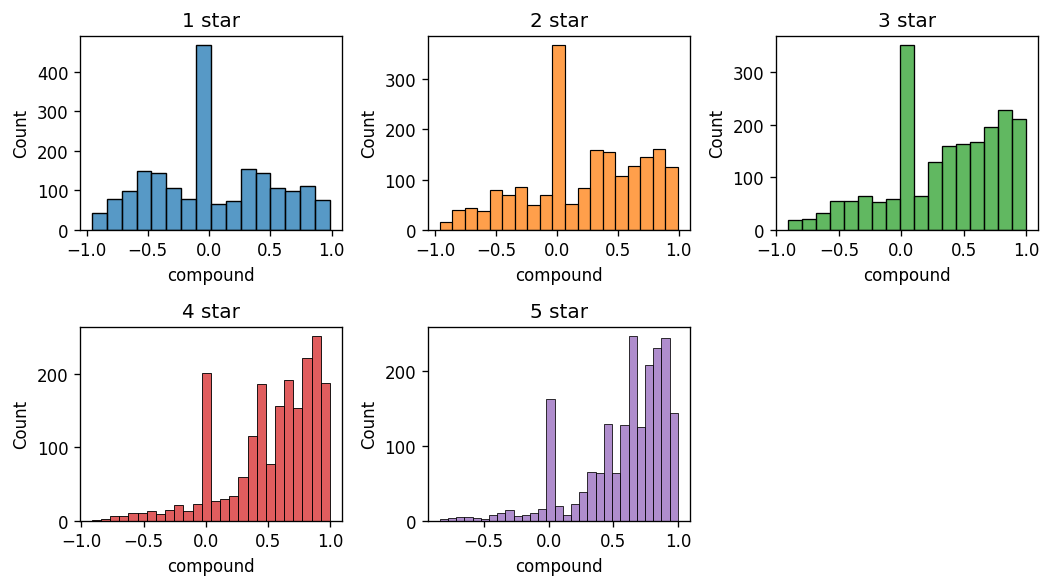

In [126]:
stars = [1,2,3,4,5]
colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(nrows=2, ncols = math.ceil(len(stars)/2), dpi = 120, figsize = (9,5))
axes = axes.flat
for i, star in enumerate(stars):
    c = next(colors)["color"]
    df_stars = df_w_sentiment[df_w_sentiment["reviewStar"] == star]
    axes[i].set_title(f"{int(star)} star")
    sns.histplot(data = df_stars, x = "compound", ax = axes[i], color=c)
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show()

Vemos que a bajas estrellas, más equilibrado el sentimiento, pero a mayor puntuación las reviews con sentimiento negativo van disminuyendo y las positivas aumentan. 

In [128]:
product_sentiment = df_w_sentiment.groupby("productID")["compound"].median()

Ahora podemos crear un sistema de recomendación mixto de contenido con sentimiento. Para ello normalizaremos la métrica compound de sentimiento, para que vaya de 0 a 1, y realizaremos una media armónica entre esta y la similitud obtenidas en el sistema de recomendación por contenido de review, de tal forma que a productos con sentimientos más negativos se le penalice, mientras que los positivos obtienen una ventaja y mayor puesto en las recomendaciones.

In [136]:
from scipy import stats

In [ ]:
def get_recs_mixed(product_id, n_recs=10):
    """
    Genera recomendaciones combinadas utilizando similitudes de reseñas y sentimientos.

    Esta función combina métricas de similitud basadas en reseñas y puntuaciones de sentimiento 
    normalizadas. Calcula una métrica adicional utilizando la media armónica y devuelve los productos 
    más relevantes al especificado.

    Parámetros:
    product_id (int o str): ID del producto para el cual se generan las recomendaciones.
    n_recs (int, opcional): Número de recomendaciones a devolver. Por defecto es 10.

    Devuelve:
    pandas.DataFrame: DataFrame con las siguientes columnas:
        - `productName`: Nombre del producto recomendado.
        - `similarity_hmean`: Media armónica entre la similitud de reseñas y el sentimiento normalizado.
        - `sentiment_norm`: Puntuación de sentimiento normalizada al rango [0, 1].
        - `similarity_review`: Similitud basada en reseñas.
    """
    print(dict_products[product_id])
    rec_prod = get_recs_from_product(product_id, n_recs=99, print_prod=False)
    rec_rev = get_recs_from_review(product_id, n_recs=99, print_prod=False)
    merged = rec_prod.merge(rec_rev, how="outer", left_on="productID", right_on="productID")
    result = pd.DataFrame()
    sentiments = product_sentiment.loc[merged["productID"]]
    norm_sentiments = (sentiments+1)/2
    
    result["productName"] = merged["productName_x"]
    result["similarity_hmean"] = stats.hmean([merged["similarity_y"], norm_sentiments])
    result["sentiment_norm"] = norm_sentiments
    result["similarity_review"] = merged["similarity_y"]
    result.index.names = ["productID"]

    return result.drop(index = product_id).sort_values(by="similarity_review", ascending=False).head(n_recs)

In [184]:
get_recs_mixed(29)

AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml


,productName,similarity_hmean,sentiment_norm,similarity_review
productID,,,,
50,Finishing Touch Flawless Women's Painless Hair...,0.795290,0.680600,0.967134
13,Hard As Hoof Nail Strengthening Cream with Coc...,0.854527,0.715475,0.964603
33,"NYX PROFESSIONAL MAKEUP Epic Ink Liner, Waterp...",0.790744,0.824300,0.964576
34,REVLON One-Step Hair Dryer And Volumizer Hot A...,0.818057,0.755300,0.963528
8,"Physicians Formula, Murumuru Butter, Bronzer, ...",0.881552,0.720200,0.963501
55,Neutrogena Hydro Boost Hyaluronic Acid Hydrati...,0.835594,0.755150,0.962338
48,Maybelline Instant Age Rewind Eraser Dark Circ...,0.797191,0.680600,0.961986
60,"Bio-Oil Skincare Oil, Body Oil for Scars and S...",0.823368,0.680600,0.961035
57,Avarelle Acne Pimple Patch (40 Count) Absorbin...,0.822545,0.738350,0.958795


Es importante recalcar que no se ha incluido las similitudes por contenido del nombre de producto. Esto se debe a que se ha calculado usando tfidf, por lo que productos que no comparten palabras tienen una similitud de 0, lo cual no indica que no sea una recomendación viable, pero la media armónica que contiene un 0 se vuelve 0.

Por ejemplo: Ratón de oficina y Teclado mecánico tendrían similitud de 0, aunque podría ser una buena recomendación si nuestro cliente está comprando accesorios electrónicos. Se debería hacer un embedding, capaz de relacionar ratón con teclado con cierta similitud.